In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

In [18]:
df = pd.read_csv("Telco_Customer_Churn.csv")
data = df.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['gender'] = (df['gender'] == 'Male').astype(int)
df['Partner'] = (df['Partner'] == 'Yes').astype(int)
df['Dependents'] = (df['Dependents'] == 'Yes').astype(int)
df['PhoneService'] = (df['PhoneService'] == 'Yes').astype(int)
df['PaperlessBilling'] = (df['PaperlessBilling'] == 'Yes').astype(int)

df['MultipleLines'] = df['MultipleLines'].replace(
    'No phone service', 'No'
)

df['MultipleLines'] = (df['MultipleLines'] == 'Yes').astype(int)

df['HasInternet'] = (df['InternetService'] != 'No').astype(int)

mapping = {
    'No': 1,
    'DSL': 2,
    'Fiber optic': 3
}

df['InternetService'] = df['InternetService'].map(mapping)

internet_cols = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

df[internet_cols] = df[internet_cols].replace('No internet service', 'No')

df[internet_cols] = (df[internet_cols] == 'Yes').astype(int)

contract_map = {
    'One year': 1, ## if start 0 -> 'inf' error Face
    'Two year': 2,
    'Month-to-month': 3
}


df['Contract'] = df['Contract'].map(contract_map)


mapping = {
    'Credit card (automatic)': 0,
    'Bank transfer (automatic)': 1,
    'Mailed check': 2,
    'Electronic check': 3
}


df['PaymentMethod'] = df['PaymentMethod'].map(mapping)

df['ElectronicPayment'] = ((df['PaperlessBilling']==1) & (df['PaymentMethod'] == 3)).astype(int)

df['Churn'] = (df['Churn'] == 'Yes').astype(int)

In [4]:
df[df['TotalCharges'] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,HasInternet,ElectronicPayment
488,4472-LVYGI,0,0,1,1,0,0,0,2,1,...,1,0,2,1,1,52.55,,0,1,0
753,3115-CZMZD,1,0,0,1,0,1,0,1,0,...,0,0,2,0,2,20.25,,0,0,0
936,5709-LVOEQ,0,0,1,1,0,1,0,2,1,...,1,1,2,0,2,80.85,,0,1,0
1082,4367-NUYAO,1,0,1,1,0,1,1,1,0,...,0,0,2,0,2,25.75,,0,0,0
1340,1371-DWPAZ,0,0,1,1,0,0,0,2,1,...,1,0,2,0,0,56.05,,0,1,0
3331,7644-OMVMY,1,0,1,1,0,1,0,1,0,...,0,0,2,0,2,19.85,,0,0,0
3826,3213-VVOLG,1,0,1,1,0,1,1,1,0,...,0,0,2,0,2,25.35,,0,0,0
4380,2520-SGTTA,0,0,1,1,0,1,0,1,0,...,0,0,2,0,2,20.00,,0,0,0
5218,2923-ARZLG,1,0,1,1,0,1,0,1,0,...,0,0,1,1,2,19.70,,0,0,0
6670,4075-WKNIU,0,0,1,1,0,1,1,2,0,...,1,0,2,0,2,73.35,,0,1,0


In [5]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df['TotalCharges'] = np.where(
    df['TotalCharges'].isna(),
    df['MonthlyCharges'], # * df['tenure'],
    df['TotalCharges']
)

df['NumOnlineServices'] = df[['OnlineSecurity','OnlineBackup','TechSupport']].apply(lambda x: sum(x==0), axis=1) # 0 -> Yes

df['Tenure_per_Contract'] = df['tenure'] / df['Contract']

In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'HasInternet', 'ElectronicPayment', 'NumOnlineServices',
       'Tenure_per_Contract'],
      dtype='object')

In [8]:

drop_cols = ['customerID','gender','Dependents','Partner','PhoneService',   'OnlineBackup','DeviceProtection','StreamingTV','StreamingMovies','InternetService']


df1 = df.drop(columns=drop_cols)
X = df1.drop('Churn', axis=1)
y = df1['Churn']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:

xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print("Best n_estimators:", xgb.best_iteration)


rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RandomForest:", acc)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




XGBoost: 0.8161816891412349
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1035
           1       0.70      0.54      0.61       374

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409

[[949  86]
 [173 201]]
Best n_estimators: 84
RandomForest: 0.8019872249822569
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

[[933 102]
 [177 197]]


ROC-AUC Score: 0.8479901314939677


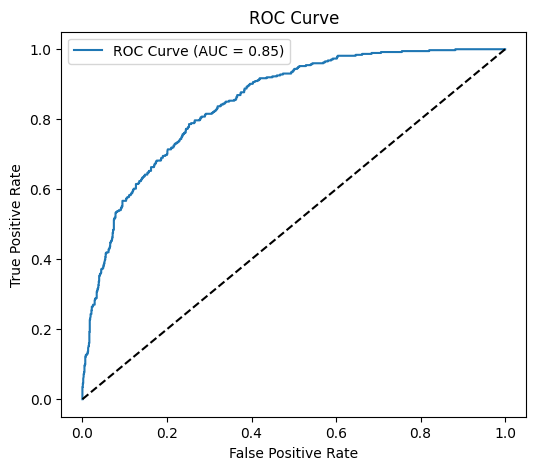

In [9]:
y_prob = xgb.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [10]:
y_prob = xgb.predict_proba(X_test)[:, 1]

y_pred_t = (y_prob >= 0.35).astype(int)

print("XGBoost:", accuracy_score(y_test, y_pred_t))
print(classification_report(y_test, y_pred_t))
print(confusion_matrix(y_test, y_pred_t))
print("Best n_estimators:", xgb.best_iteration)

XGBoost: 0.7757274662881476
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.70      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409

[[832 203]
 [113 261]]
Best n_estimators: 84


In [11]:
from sklearn.metrics import precision_score, recall_score
y_prob = xgb.predict_proba(X_test)[:, 1]


for t in [0.2, 0.3, 0.4, 0.1,0.35,0.4,0.45,0.5]:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"Threshold {t}:",
        "Precision =", round(precision_score(y_test, y_pred_t), 2),
        "Recall =", round(recall_score(y_test, y_pred_t), 2)
    )

    print("XGBoost:", accuracy_score(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))
    print(confusion_matrix(y_test, y_pred_t))
    print("Best n_estimators:", xgb.best_iteration)

Threshold 0.2: Precision = 0.48 Recall = 0.84
XGBoost: 0.7132718239886444
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1035
           1       0.48      0.84      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.71      0.73      1409

[[690 345]
 [ 59 315]]
Best n_estimators: 84
Threshold 0.3: Precision = 0.53 Recall = 0.75
XGBoost: 0.7601135557132718
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

[[791 244]
 [ 94 280]]
Best n_estimators: 84
Threshold 0.4: Precision = 0.6 Recall = 0.64
XGBoost: 0.7927608232789212
              precision    recall  

/home/ahmed/miniconda3/envs/ml/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


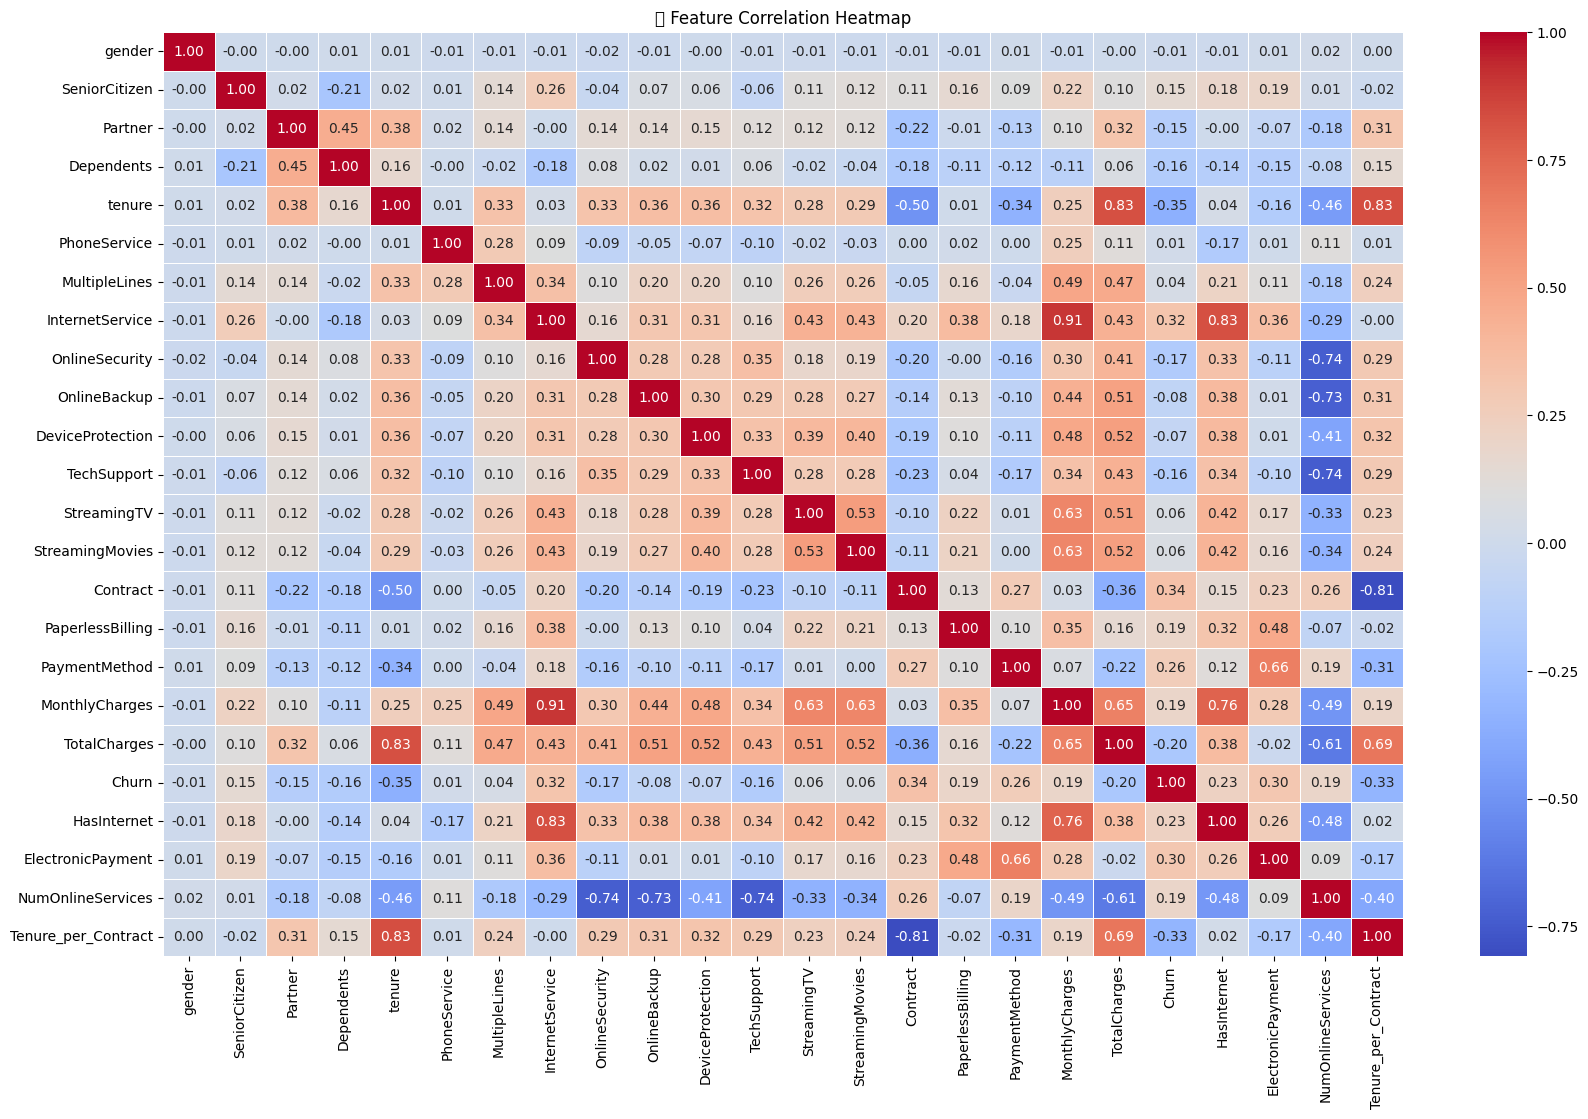

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("📊 Feature Correlation Heatmap")
plt.show()



In [13]:
df1.columns

Index(['SeniorCitizen', 'tenure', 'MultipleLines', 'OnlineSecurity',
       'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'HasInternet',
       'ElectronicPayment', 'NumOnlineServices', 'Tenure_per_Contract'],
      dtype='object')

## df2

In [14]:

drop_cols = ['customerID']


df2 = df.drop(columns=drop_cols)
X = df2.drop('Churn', axis=1)
y = df2['Churn']

In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print("Best n_estimators:", xgb.best_iteration)


rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RandomForest:", acc)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




XGBoost: 0.8055358410220014
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

[[933 102]
 [172 202]]
Best n_estimators: 80
RandomForest: 0.8026969481902059
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

[[929 106]
 [172 202]]


In [16]:
from sklearn.metrics import precision_score, recall_score
y_prob = xgb.predict_proba(X_test)[:, 1]


for t in [0.2, 0.3, 0.4, 0.1,0.35,0.4,0.45,0.5]:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"Threshold {t}:",
        "Precision =", round(precision_score(y_test, y_pred_t), 2),
        "Recall =", round(recall_score(y_test, y_pred_t), 2)
    )

    print("XGBoost:", accuracy_score(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))
    print(confusion_matrix(y_test, y_pred_t))
    print("Best n_estimators:", xgb.best_iteration)

Threshold 0.2: Precision = 0.48 Recall = 0.86
XGBoost: 0.716820440028389
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      1035
           1       0.48      0.86      0.62       374

    accuracy                           0.72      1409
   macro avg       0.70      0.76      0.70      1409
weighted avg       0.81      0.72      0.73      1409

[[690 345]
 [ 54 320]]
Best n_estimators: 80
Threshold 0.3: Precision = 0.54 Recall = 0.78
XGBoost: 0.7672107877927609
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1035
           1       0.54      0.78      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409

[[790 245]
 [ 83 291]]
Best n_estimators: 80
Threshold 0.4: Precision = 0.59 Recall = 0.64
XGBoost: 0.7877927608232789
              precision    recall  

## df3

In [17]:
df3 = pd.read_csv('Telco_Customer_Churn.csv')


In [18]:
df3

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [19]:
from sklearn.preprocessing import OneHotEncoder

df3['TotalCharges']=pd.to_numeric(df3['TotalCharges'],errors='coerce')
df3['Churn']=df3['Churn'].map({'Yes':1,'No':0})

df3.drop(columns=['customerID','gender','PhoneService','MultipleLines'],axis=1,inplace=True)
X = df3.drop(columns=['Churn'],axis=1)
y = df3['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

cul_cat = [col for col in X.columns if X[col].dtype=='object']
cul_num = [col for col in X.columns if X[col].dtype!='object']

encoder = OneHotEncoder(drop='first',sparse_output=False)
encoder.fit(X_train[cul_cat])
X_train_cat = encoder.transform(X_train[cul_cat])
X_test_cat = encoder.transform(X_test[cul_cat])

X_train_full = np.concatenate((X_train_cat,X_train[cul_num].values),axis=1)
X_test_full = np.concatenate((X_test_cat,X_test[cul_num].values),axis=1)

In [24]:
X_train_full

array([[1.00000e+00, 1.00000e+00, 0.00000e+00, ..., 7.20000e+01,
        5.36500e+01, 3.78400e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 4.00000e+00,
        4.60000e+01, 1.93600e+02],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 5.60000e+01,
        2.12000e+01, 1.23865e+03],
       ...,
       [1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 7.10000e+01,
        1.09250e+02, 7.70770e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.40000e+01,
        2.04000e+01, 4.82800e+02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 6.00000e+00,
        2.06500e+01, 1.09300e+02]], shape=(5282, 26))

In [25]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(X_train_full,y_train,
        eval_set=[(X_test_full, y_test)],
        verbose=False)
y_pred_xgb = xgb.predict(X_test_full)

print("XGBoost:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print("Best n_estimators:", xgb.best_iteration)

XGBoost: 0.7989778534923339
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1294
           1       0.66      0.50      0.57       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761

[[1175  119]
 [ 235  232]]
Best n_estimators: 69


In [26]:

xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=50,
    random_state=42
)
xgb.fit(X_train_full, y_train,
        eval_set=[(X_test_full, y_test)],
        verbose=False)
y_pred_xgb = xgb.predict(X_test_full)

print("XGBoost:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print("Best n_estimators:", xgb.best_iteration)


rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train_full, y_train)
y_pred = rf_model.predict(X_test_full)
acc = accuracy_score(y_test, y_pred)
print("RandomForest:", acc)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




XGBoost: 0.7989778534923339
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1294
           1       0.66      0.50      0.57       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761

[[1175  119]
 [ 235  232]]
Best n_estimators: 69
RandomForest: 0.8018171493469619
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1294
           1       0.67      0.51      0.58       467

    accuracy                           0.80      1761
   macro avg       0.75      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761

[[1175  119]
 [ 230  237]]


In [28]:
y_prob = xgb.predict_proba(X_test_full)[:, 1]

y_pred_t = (y_prob >= 0.3).astype(int)

print("XGBoost:", accuracy_score(y_test, y_pred_t))
print(classification_report(y_test, y_pred_t))
print(confusion_matrix(y_test, y_pred_t))
print("Best n_estimators:", xgb.best_iteration)

XGBoost: 0.768313458262351
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1294
           1       0.54      0.77      0.64       467

    accuracy                           0.77      1761
   macro avg       0.72      0.77      0.73      1761
weighted avg       0.81      0.77      0.78      1761

[[993 301]
 [107 360]]
Best n_estimators: 69


In [ ]:
from sklearn.metrics import precision_score, recall_score
y_prob = xgb.predict_proba(X_test_full)[:, 1]


for t in [0.3, 0.4,0.35,0.4,0.45,0.5]:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"Threshold {t}:",
        "Precision =", round(precision_score(y_test, y_pred_t), 2),
        "Recall =", round(recall_score(y_test, y_pred_t), 2)
    )

    print("XGBoost:", accuracy_score(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))
    print(confusion_matrix(y_test, y_pred_t))
    print("Best n_estimators:", xgb.best_iteration)

In [29]:
import joblib
# Save the best model to disk
joblib.dump(xgb, "best_model.pkl")
print("Best model saved as best_model.pkl")

Best model saved as best_model.pkl


## process

In [19]:
data = data.copy()

In [20]:
cols_to_drop = ['customerID', 'gender', 'PhoneService', 'MultipleLines']
data = data.drop(columns=cols_to_drop)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')


X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

cul_cat = [col for col in X.columns if X[col].dtype == 'object']
cul_num = [col for col in X.columns if X[col].dtype != 'object']

In [ ]:

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[cul_cat])
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib

try:
    encoder = joblib.load("encoder.pkl")
except:
    encoder = None

def process_data(df: pd.DataFrame,encoder):
    data = df.copy()


    if 'TotalCharges' in data.columns:
        data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
        data['TotalCharges'] = data['TotalCharges'].fillna(0)

    cols_to_drop = ['customerID', 'gender', 'PhoneService', 'MultipleLines']
    data.drop(columns=[c for c in cols_to_drop if c in data.columns], axis=1, inplace=True)

    X = data.drop(columns=['Churn']) if 'Churn' in data.columns else data
    
    cul_cat = [col for col in X.columns if X[col].dtype == 'object']
    cul_num = [col for col in X.columns if X[col].dtype != 'object']

    if encoder:
        df_cat = encoder.transform(X[cul_cat])
    else:
        raise Exception("Encoder not found! Please provide encoder.pkl")

    processed_data = np.concatenate((df_cat, X[cul_num].values), axis=1)

    return processed_data


df_processed = process_data(data,encoder)

In [23]:
df_processed

array([[1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 2.9850e+01,
        2.9850e+01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 3.4000e+01, 5.6950e+01,
        1.8895e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.0000e+00, 5.3850e+01,
        1.0815e+02],
       ...,
       [1.0000e+00, 1.0000e+00, 0.0000e+00, ..., 1.1000e+01, 2.9600e+01,
        3.4645e+02],
       [1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 4.0000e+00, 7.4400e+01,
        3.0660e+02],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 6.6000e+01, 1.0565e+02,
        6.8445e+03]], shape=(7043, 26))

In [28]:
model_pipeline = joblib.load("best_model.pkl")
prediction = model_pipeline.predict(df_processed)[0]

In [29]:
prediction

np.int64(1)